# Feature engineering on bureau and bureau_balance datasets

Based on Will Koehrsen's and Shanth Kaggle Notebooks, availiable at: 
- https://www.kaggle.com/willkoehrsen/introduction-to-manual-feature-engineering
- https://www.kaggle.com/shanth84/home-credit-bureau-data-feature-engineering

In [22]:
# Librairies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scripts import fe_scripts as fe

# Options
pd.set_option('display.max_columns', 200)
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Manual Feature engineering on Bureau

In [2]:
# Importing datasets
df_bureau = pd.read_csv('../data/data_inputs/bureau.csv')
df_app = pd.read_pickle('../data/data_outputs/feature_engineered/application.pkl')

In [3]:
df_bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


## Number of previous loans

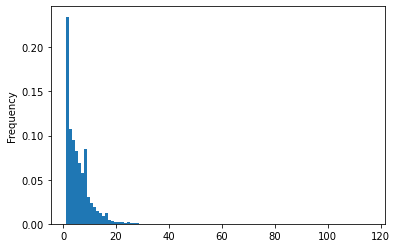

count    305811.000000
mean          5.612709
std           4.430354
min           1.000000
25%           2.000000
50%           4.000000
75%           8.000000
max         116.000000
Name: SK_ID_BUREAU, dtype: float64

In [4]:
# Distribution of previous loans
count_loans = df_bureau.groupby('SK_ID_CURR', as_index = False).agg({'SK_ID_BUREAU' : 'count'})
count_loans['SK_ID_BUREAU'].plot(kind = 'hist', density = 'True', bins = 100)
plt.show()

count_loans['SK_ID_BUREAU'].describe()

In [5]:
# Merge in application dataset
count_loans.rename(columns = {'SK_ID_BUREAU' : 'NB_PREVIOUS_LOANS'}, inplace=True)
df_app = df_app.merge(count_loans, on = 'SK_ID_CURR', how = 'left')
df_app['NB_PREVIOUS_LOANS'].fillna(0, inplace = True)

## Mean number of loans per loan type

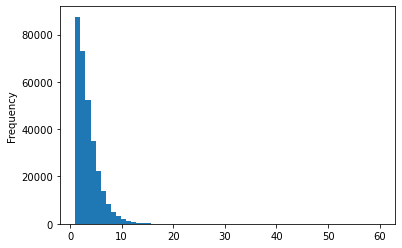

count    305811.000000
mean          3.149719
std           2.212574
min           1.000000
25%           1.500000
50%           2.500000
75%           4.000000
max          60.000000
Name: AVG_LOAN_TYPE, dtype: float64

In [6]:
# Mean number of loans per loan type per customer
grp = df_bureau.groupby('SK_ID_CURR', as_index = False).agg(
    {'SK_ID_BUREAU' : 'count',
     'CREDIT_TYPE' : 'nunique'}
)
grp['AVG_LOAN_TYPE'] = grp['SK_ID_BUREAU']/grp['CREDIT_TYPE']
grp['AVG_LOAN_TYPE'].plot(kind = 'hist', bins = 60)
plt.show()

grp['AVG_LOAN_TYPE'].describe()

In [7]:
# Merge in main dataset
df_app = df_app.merge(grp[['SK_ID_CURR', 'AVG_LOAN_TYPE']], on = 'SK_ID_CURR', how = 'left')
df_app['AVG_LOAN_TYPE'].fillna(0, inplace = True)

## Proportion of active loans

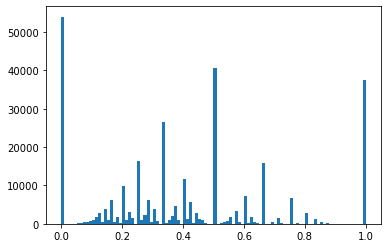

count    305811.000000
mean          0.410223
std           0.307228
min           0.000000
25%           0.200000
50%           0.375000
75%           0.600000
max           1.000000
Name: %_ACTIVE_CREDITS, dtype: float64

In [8]:
# Calculate % of active credits per client
df_bureau['IS_CREDIT_ACTIVE'] =(df_bureau['CREDIT_ACTIVE'] == 'Active')
grp = df_bureau.groupby(by = 'SK_ID_CURR', as_index = False).agg({'IS_CREDIT_ACTIVE' : 'mean'})
grp.rename(columns = {'IS_CREDIT_ACTIVE' : '%_ACTIVE_CREDITS'}, inplace = True)

plt.hist(grp['%_ACTIVE_CREDITS'], bins = 100)
plt.show()

grp['%_ACTIVE_CREDITS'].describe()

In [9]:
# Merge in main dataset
df_app = df_app.merge(grp, on = 'SK_ID_CURR', how = 'left')
df_app['%_ACTIVE_CREDITS'].fillna(0, inplace = True)

## Average number of days between successive applications

In [10]:
grp = df_bureau[['SK_ID_CURR', 'SK_ID_BUREAU', 'DAYS_CREDIT']].groupby(by = 'SK_ID_CURR')
grp = grp.apply(lambda x: x.sort_values(['DAYS_CREDIT'], ascending = False)).reset_index(drop = True)
grp['DAYS_CREDIT'] = -grp['DAYS_CREDIT']
grp['DAYS_DIFF'] = grp.groupby(by = ['SK_ID_CURR'])['DAYS_CREDIT'].diff()
grp = grp.groupby(by = ['SK_ID_CURR'], as_index = False).agg({'DAYS_DIFF' : 'mean'})

In [11]:
# Merge in main dataset
grp.rename(columns = {'DAYS_DIFF' : 'MEAN_DAYS_BTW_APPLICATIONS'}, inplace = True)
df_app = df_app.merge(grp, on = 'SK_ID_CURR', how = 'left')

## Debt over credit ration

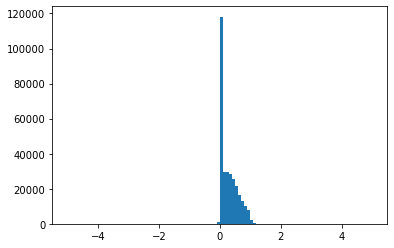

count    304535.000000
mean          0.282770
std           0.291676
min          -5.000000
25%           0.000000
50%           0.210886
75%           0.481842
max           5.000000
Name: DEBT_CREDIT_RATIO, dtype: float64

In [12]:
# Calculation
df_bureau['AMT_CREDIT_SUM_DEBT'] = df_bureau['AMT_CREDIT_SUM_DEBT'].fillna(0)
df_bureau['AMT_CREDIT_SUM'] = df_bureau['AMT_CREDIT_SUM'].fillna(0)

grp = df_bureau.groupby(by = 'SK_ID_CURR', as_index = False)[['AMT_CREDIT_SUM_DEBT', 'AMT_CREDIT_SUM']].sum()
grp['DEBT_CREDIT_RATIO'] = grp['AMT_CREDIT_SUM_DEBT'] / grp['AMT_CREDIT_SUM']
grp['DEBT_CREDIT_RATIO'] = grp['DEBT_CREDIT_RATIO'].replace(np.inf, np.nan)
grp['DEBT_CREDIT_RATIO'] = grp['DEBT_CREDIT_RATIO'].replace(-np.inf, np.nan)
grp['DEBT_CREDIT_RATIO'] = np.clip(grp['DEBT_CREDIT_RATIO'], -5, 5)

plt.hist(grp['DEBT_CREDIT_RATIO'], bins = 100)
plt.show()
grp['DEBT_CREDIT_RATIO'].describe()

In [13]:
# Merge in main dataset
df_app = df_app.merge(grp[['SK_ID_CURR', 'DEBT_CREDIT_RATIO']], on = 'SK_ID_CURR', how = 'left')

## Overdue over debt ratio

In [14]:
# Calculation
df_bureau['AMT_CREDIT_SUM_DEBT'] = df_bureau['AMT_CREDIT_SUM_DEBT'].fillna(0)
df_bureau['AMT_CREDIT_SUM_OVERDUE'] = df_bureau['AMT_CREDIT_SUM_OVERDUE'].fillna(0)

grp = df_bureau.groupby('SK_ID_CURR', as_index = False)[['AMT_CREDIT_SUM_DEBT', 'AMT_CREDIT_SUM_OVERDUE']].sum()
grp['OVERDUE_DEBT_RATIO'] = grp['AMT_CREDIT_SUM_OVERDUE']/grp['AMT_CREDIT_SUM_DEBT']

In [15]:
# Merge in main dataset
df_app = df_app.merge(grp[['SK_ID_CURR', 'OVERDUE_DEBT_RATIO']], on = 'SK_ID_CURR', how = 'left')

## Mean number of times a loan was prolonged

In [16]:
# Calculation
df_bureau['CNT_CREDIT_PROLONG'] = df_bureau['CNT_CREDIT_PROLONG'].fillna(0)
grp = df_bureau.groupby('SK_ID_CURR', as_index = False)['CNT_CREDIT_PROLONG'].mean()

In [17]:
# Merge
grp.rename(columns = {'CNT_CREDIT_PROLONG' : 'AVG_CNT_PROLONGED'}, inplace = True)
df_app = df_app.merge(grp, on = 'SK_ID_CURR', how = 'left')
df_app['AVG_CNT_PROLONGED'] = df_app['AVG_CNT_PROLONGED'].fillna(0)

# "Brute-force" Feature engineering

In [18]:
# Group by the client id, calculate aggregation statistics
bureau_agg = df_bureau.drop(columns = ['SK_ID_BUREAU']).groupby('SK_ID_CURR', as_index = False).agg(['count', 'mean', 'max', 'min', 'sum']).reset_index()
bureau_agg.head()

SK_ID_CURR DAYS_CREDIT                               CREDIT_DAY_OVERDUE  \
                   count         mean  max   min   sum              count   
0     100001           7  -735.000000  -49 -1572 -5145                  7   
1     100002           8  -874.000000 -103 -1437 -6992                  8   
2     100003           4 -1400.750000 -606 -2586 -5603                  4   
3     100004           2  -867.000000 -408 -1326 -1734                  2   
4     100005           3  -190.666667  -62  -373  -572                  3   

                   DAYS_CREDIT_ENDDATE                                      \
  mean max min sum               count        mean     max     min     sum   
0  0.0   0   0   0                   7   82.428571  1778.0 -1329.0   577.0   
1  0.0   0   0   0                   6 -349.000000   780.0 -1072.0 -2094.0   
2  0.0   0   0   0                   4 -544.500000  1216.0 -2434.0 -2178.0   
3  0.0   0   0   0                   2 -488.500000  -382.0  -595.0  -977.0   
4  0.0   0   0   0                   3  439.333333  1324.0  -128.0  1318.0   

  DAYS_ENDDATE_FACT                                      \
              count         mean    max     min     sum   
0                 4  -825.500000 -544.0 -1328.0 -3302.0   
1                 6  -697.500000  -36.0 -1185.0 -4185.0   
2                 3 -1097.333333 -540.0 -2131.0 -3292.0   
3                 2  -532.500000 -382.0  -683.0 -1065.0   
4                 1  -123.000000 -123.0  -123.0  -123.0   

  AMT_CREDIT_MAX_OVERDUE                                     \
                   count      mean       max  min       sum   
0                      0       NaN       NaN  NaN     0.000   
1                      5  1681.029  5043.645  0.0  8405.145   
2                      4     0.000     0.000  0.0     0.000   
3                      1     0.000     0.000  0.0     0.000   
4                      1     0.000     0.000  0.0     0.000   

  CNT_CREDIT_PROLONG                  AMT_CREDIT_SUM                           \
               count mean max min sum          count           mean       max   
0                  7  0.0   0   0   0              7  207623.571429  378000.0   
1                  8  0.0   0   0   0              8  108131.945625  450000.0   
2                  4  0.0   0   0   0              4  254350.125000  810000.0   
3                  2  0.0   0   0   0              2   94518.900000   94537.8   
4                  3  0.0   0   0   0              3  219042.000000  568800.0   

                        AMT_CREDIT_SUM_DEBT                                \
       min          sum               count           mean       max  min   
0  85500.0  1453365.000                   7   85240.928571  373239.0  0.0   
1      0.0   865055.565                   8   30722.625000  245781.0  0.0   
2  22248.0  1017400.500                   4       0.000000       0.0  0.0   
3  94500.0   189037.800                   2       0.000000       0.0  0.0   
4  29826.0   657126.000                   3  189469.500000  543087.0  0.0   

            AMT_CREDIT_SUM_LIMIT                                             \
        sum                count          mean         max  min         sum   
0  596686.5                    6       0.00000       0.000  0.0       0.000   
1  245781.0                    4    7997.14125   31988.565  0.0   31988.565   
2       0.0                    4  202500.00000  810000.000  0.0  810000.000   
3       0.0                    2       0.00000       0.000  0.0       0.000   
4  568408.5                    3       0.00000       0.000  0.0       0.000   

  AMT_CREDIT_SUM_OVERDUE                     DAYS_CREDIT_UPDATE              \
                   count mean  max  min  sum              count        mean   
0                      7  0.0  0.0  0.0  0.0                  7  -93.142857   
1                      8  0.0  0.0  0.0  0.0                  8 -499.875000   
2                      4  0.0  0.0  0.0  0.0                  4 -816.000000   
3 

In [19]:
# List of column names
columns = ['SK_ID_CURR']

# Iterate through the variables names
for var in bureau_agg.columns.levels[0]:
    # Skip the id name
    if var != 'SK_ID_CURR':
        
        # Iterate through the stat names
        for stat in bureau_agg.columns.levels[1][:-1]:
            # Make a new column name for the variable and stat
            columns.append('bureau_%s_%s' % (var, stat))
            
# Assign the list of columns names as the dataframe column names
bureau_agg.columns = columns
bureau_agg.head()

,SK_ID_CURR,bureau_DAYS_CREDIT_count,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_sum,bureau_CREDIT_DAY_OVERDUE_count,bureau_CREDIT_DAY_OVERDUE_mean,bureau_CREDIT_DAY_OVERDUE_max,bureau_CREDIT_DAY_OVERDUE_min,bureau_CREDIT_DAY_OVERDUE_sum,bureau_DAYS_CREDIT_ENDDATE_count,bureau_DAYS_CREDIT_ENDDATE_mean,bureau_DAYS_CREDIT_ENDDATE_max,bureau_DAYS_CREDIT_ENDDATE_min,bureau_DAYS_CREDIT_ENDDATE_sum,bureau_DAYS_ENDDATE_FACT_count,bureau_DAYS_ENDDATE_FACT_mean,bureau_DAYS_ENDDATE_FACT_max,bureau_DAYS_ENDDATE_FACT_min,bureau_DAYS_ENDDATE_FACT_sum,bureau_AMT_CREDIT_MAX_OVERDUE_count,bureau_AMT_CREDIT_MAX_OVERDUE_mean,bureau_AMT_CREDIT_MAX_OVERDUE_max,bureau_AMT_CREDIT_MAX_OVERDUE_min,bureau_AMT_CREDIT_MAX_OVERDUE_sum,bureau_CNT_CREDIT_PROLONG_count,bureau_CNT_CREDIT_PROLONG_mean,bureau_CNT_CREDIT_PROLONG_max,bureau_CNT_CREDIT_PROLONG_min,bureau_CNT_CREDIT_PROLONG_sum,bureau_AMT_CREDIT_SUM_count,bureau_AMT_CREDIT_SUM_mean,bureau_AMT_CREDIT_SUM_max,bureau_AMT_CREDIT_SUM_min,bureau_AMT_CREDIT_SUM_sum,bureau_AMT_CREDIT_SUM_DEBT_count,bureau_AMT_CREDIT_SUM_DEBT_mean,bureau_AMT_CREDIT_SUM_DEBT_max,bureau_AMT_CREDIT_SUM_DEBT_min,bureau_AMT_CREDIT_SUM_DEBT_sum,bureau_AMT_CREDIT_SUM_LIMIT_count,bureau_AMT_CREDIT_SUM_LIMIT_mean,bureau_AMT_CREDIT_SUM_LIMIT_max,bureau_AMT_CREDIT_SUM_LIMIT_min,bureau_AMT_CREDIT_SUM_LIMIT_sum,bureau_AMT_CREDIT_SUM_OVERDUE_count,bureau_AMT_CREDIT_SUM_OVERDUE_mean,bureau_AMT_CREDIT_SUM_OVERDUE_max,bureau_AMT_CREDIT_SUM_OVERDUE_min,bureau_AMT_CREDIT_SUM_OVERDUE_sum,bureau_DAYS_CREDIT_UPDATE_count,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_sum,bureau_AMT_ANNUITY_count,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_min,bureau_AMT_ANNUITY_sum,bureau_IS_CREDIT_ACTIVE_count,bureau_IS_CREDIT_ACTIVE_mean,bureau_IS_CREDIT_ACTIVE_max,bureau_IS_CREDIT_ACTIVE_min,bureau_IS_CREDIT_ACTIVE_sum
0,100001,7,-735.000000,-49,-1572,-5145,7,0.0,0,0,0,7,82.428571,1778.0,-1329.0,577.0,4,-825.500000,-544.0,-1328.0,-3302.0,0,NaN,NaN,NaN,0.000,7,0.0,0,0,0,7,207623.571429,378000.0,85500.0,1453365.000,7,85240.928571,373239.0,0.0,596686.5,6,0.00000,0.000,0.0,0.000,7,0.0,0.0,0.0,0.0,7,-93.142857,-6,-155,-652,7,3545.357143,10822.5,0.0,24817.5,7,0.428571,True,False,3.0
1,100002,8,-874.000000,-103,-1437,-6992,8,0.0,0,0,0,6,-349.000000,780.0,-1072.0,-2094.0,6,-697.500000,-36.0,-1185.0,-4185.0,5,1681.029,5043.645,0.0,8405.145,8,0.0,0,0,0,8,108131.945625,450000.0,0.0,865055.565,8,30722.625000,245781.0,0.0,245781.0,4,7997.14125,31988.565,0.0,31988.565,8,0.0,0.0,0.0,0.0,8,-499.875000,-7,-1185,-3999,7,0.000000,0.0,0.0,0.0,8,0.250000,True,False,2.0
2,100003,4,-1400.750000,-606,-2586,-5603,4,0.0,0,0,0,4,-544.500000,1216.0,-2434.0,-2178.0,3,-1097.333333,-540.0,-2131.0,-3292.0,4,0.000,0.000,0.0,0.000,4,0.0,0,0,0,4,254350.125000,810000.0,22248.0,1017400.500,4,0.000000,0.0,0.0,0.0,4,202500.00000,810000.000,0.0,810000.000,4,0.0,0.0,0.0,0.0,4,-816.000000,-43,-2131,-3264,0,NaN,NaN,NaN,0.0,4,0.250000,True,False,1.0
3,100004,2,-867.000000,-408,-1326,-1734,2,0.0,0,0,0,2,-488.500000,-382.0,-595.0,-977.0,2,-532.500000,-382.0,-683.0,-1065.0,1,0.000,0.000,0.0,0.000,2,0.0,0,0,0,2,94518.900000,94537.8,94500.0,189037.800,2,0.000000,0.0,0.0,0.0,2,0.00000,0.000,0.0,0.000,2,0.0,0.0,0.0,0.0,2,-532.000000,-382,-682,-1064,0,NaN,NaN,NaN,0.0,2,0.000000,False,False,0.0
4,100005,3,-190.666667,-62,-373,-572,3,0.0,0,0,0,3,439.333333,1324.0,-128.0,1318.0,1,-123.000000,-123.0,-123.0,-123.0,1,0.000,0.000,0.0,0.000,3,0.0,0,0,0,3,219042.000000,568800.0,29826.0,657126.000,3,189469.500000,543087.0,0.0,568408.5,3,0.00000,0.000,0.0,0.000,3,0.0,0.0,0.0,0.0,3,-54.333333,-11,-121,-163,3,1420.500000,4261.5,0.0,4261.5,3,0.666667,True,False,2.0


In [23]:
bureau_agg_new = fe.agg_numeric(df_bureau.drop(columns = ['SK_ID_BUREAU']), group_var = 'SK_ID_CURR', df_name = 'bureau')
bureau_agg_new.head()

C:\Users\alexa_000\Documents\Alex\Data Science\Parcours Data Scientist\Projet 7 - Implémentez un modèle de scoring\ParcoursDS_Projet7\01_feature_engineering\scripts\fe_scripts.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_df[group_var] = group_ids


,SK_ID_CURR,bureau_DAYS_CREDIT_count,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_sum,bureau_CREDIT_DAY_OVERDUE_count,bureau_CREDIT_DAY_OVERDUE_mean,bureau_CREDIT_DAY_OVERDUE_max,bureau_CREDIT_DAY_OVERDUE_min,bureau_CREDIT_DAY_OVERDUE_sum,bureau_DAYS_CREDIT_ENDDATE_count,bureau_DAYS_CREDIT_ENDDATE_mean,bureau_DAYS_CREDIT_ENDDATE_max,bureau_DAYS_CREDIT_ENDDATE_min,bureau_DAYS_CREDIT_ENDDATE_sum,bureau_DAYS_ENDDATE_FACT_count,bureau_DAYS_ENDDATE_FACT_mean,bureau_DAYS_ENDDATE_FACT_max,bureau_DAYS_ENDDATE_FACT_min,bureau_DAYS_ENDDATE_FACT_sum,bureau_AMT_CREDIT_MAX_OVERDUE_count,bureau_AMT_CREDIT_MAX_OVERDUE_mean,bureau_AMT_CREDIT_MAX_OVERDUE_max,bureau_AMT_CREDIT_MAX_OVERDUE_min,bureau_AMT_CREDIT_MAX_OVERDUE_sum,bureau_CNT_CREDIT_PROLONG_count,bureau_CNT_CREDIT_PROLONG_mean,bureau_CNT_CREDIT_PROLONG_max,bureau_CNT_CREDIT_PROLONG_min,bureau_CNT_CREDIT_PROLONG_sum,bureau_AMT_CREDIT_SUM_count,bureau_AMT_CREDIT_SUM_mean,bureau_AMT_CREDIT_SUM_max,bureau_AMT_CREDIT_SUM_min,bureau_AMT_CREDIT_SUM_sum,bureau_AMT_CREDIT_SUM_DEBT_count,bureau_AMT_CREDIT_SUM_DEBT_mean,bureau_AMT_CREDIT_SUM_DEBT_max,bureau_AMT_CREDIT_SUM_DEBT_min,bureau_AMT_CREDIT_SUM_DEBT_sum,bureau_AMT_CREDIT_SUM_LIMIT_count,bureau_AMT_CREDIT_SUM_LIMIT_mean,bureau_AMT_CREDIT_SUM_LIMIT_max,bureau_AMT_CREDIT_SUM_LIMIT_min,bureau_AMT_CREDIT_SUM_LIMIT_sum,bureau_AMT_CREDIT_SUM_OVERDUE_count,bureau_AMT_CREDIT_SUM_OVERDUE_mean,bureau_AMT_CREDIT_SUM_OVERDUE_max,bureau_AMT_CREDIT_SUM_OVERDUE_min,bureau_AMT_CREDIT_SUM_OVERDUE_sum,bureau_DAYS_CREDIT_UPDATE_count,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_sum,bureau_AMT_ANNUITY_count,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_min,bureau_AMT_ANNUITY_sum
0,100001,7,-735.000000,-49,-1572,-5145,7,0.0,0,0,0,7,82.428571,1778.0,-1329.0,577.0,4,-825.500000,-544.0,-1328.0,-3302.0,0,NaN,NaN,NaN,0.000,7,0.0,0,0,0,7,207623.571429,378000.0,85500.0,1453365.000,7,85240.928571,373239.0,0.0,596686.5,6,0.00000,0.000,0.0,0.000,7,0.0,0.0,0.0,0.0,7,-93.142857,-6,-155,-652,7,3545.357143,10822.5,0.0,24817.5
1,100002,8,-874.000000,-103,-1437,-6992,8,0.0,0,0,0,6,-349.000000,780.0,-1072.0,-2094.0,6,-697.500000,-36.0,-1185.0,-4185.0,5,1681.029,5043.645,0.0,8405.145,8,0.0,0,0,0,8,108131.945625,450000.0,0.0,865055.565,8,30722.625000,245781.0,0.0,245781.0,4,7997.14125,31988.565,0.0,31988.565,8,0.0,0.0,0.0,0.0,8,-499.875000,-7,-1185,-3999,7,0.000000,0.0,0.0,0.0
2,100003,4,-1400.750000,-606,-2586,-5603,4,0.0,0,0,0,4,-544.500000,1216.0,-2434.0,-2178.0,3,-1097.333333,-540.0,-2131.0,-3292.0,4,0.000,0.000,0.0,0.000,4,0.0,0,0,0,4,254350.125000,810000.0,22248.0,1017400.500,4,0.000000,0.0,0.0,0.0,4,202500.00000,810000.000,0.0,810000.000,4,0.0,0.0,0.0,0.0,4,-816.000000,-43,-2131,-3264,0,NaN,NaN,NaN,0.0
3,100004,2,-867.000000,-408,-1326,-1734,2,0.0,0,0,0,2,-488.500000,-382.0,-595.0,-977.0,2,-532.500000,-382.0,-683.0,-1065.0,1,0.000,0.000,0.0,0.000,2,0.0,0,0,0,2,94518.900000,94537.8,94500.0,189037.800,2,0.000000,0.0,0.0,0.0,2,0.00000,0.000,0.0,0.000,2,0.0,0.0,0.0,0.0,2,-532.000000,-382,-682,-1064,0,NaN,NaN,NaN,0.0
4,100005,3,-190.666667,-62,-373,-572,3,0.0,0,0,0,3,439.333333,1324.0,-128.0,1318.0,1,-123.000000,-123.0,-123.0,-123.0,1,0.000,0.000,0.0,0.000,3,0.0,0,0,0,3,219042.000000,568800.0,29826.0,657126.000,3,189469.500000,543087.0,0.0,568408.5,3,0.00000,0.000,0.0,0.000,3,0.0,0.0,0.0,0.0,3,-54.333333,-11,-121,-163,3,1420.500000,4261.5,0.0,4261.5
